In [1]:
import  numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import plotly.express as px
import lightgbm as lgb

from sklearn.model_selection import train_test_split#
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

px_template = "simple white"

In [2]:
data = pd.read_csv('./data/diabetes_012_health_indicators_BRFSS2015.csv')

# **1. Data Analysis**

Data: https://www.kaggle.com/code/bharat04/diabetes-detailed-eda-with-conclusion/data

target variable Diabetes_012:
- 0 : no diabetes/ only during pregnancy
- 1 : prediabetes
- 2 : diabetes


## Summary: 

- 22 features (15 Discrete & 7 continuous)
- major feature variables for Diabetes are : HIghBP , HighChol , BMI , Stroke , GenHlth , MentHlth , PhysHlth , Age , Eduation and Income.
- Feature increasing diabetesrisk seem to be: Smoking and HvyAlcoholConsump , Stroke and HeartDiseaseorAttack , HighBP and HighChol.
- Features with least effect are: PhysActivity , Fruits , Veggies , AnyHealthcare , CholChek. (They seem to help in decreasing the risk)

In [3]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Diabetes_012,253680.0,0.296921,0.698160,0.0,0.0,0.0,0.0,2.0
HighBP,253680.0,0.429001,0.494934,0.0,0.0,0.0,1.0,1.0
HighChol,253680.0,0.424121,0.494210,0.0,0.0,0.0,1.0,1.0
CholCheck,253680.0,0.962670,0.189571,0.0,1.0,1.0,1.0,1.0
BMI,253680.0,28.382364,6.608694,12.0,24.0,27.0,31.0,98.0
Smoker,253680.0,0.443169,0.496761,0.0,0.0,0.0,1.0,1.0
Stroke,253680.0,0.040571,0.197294,0.0,0.0,0.0,0.0,1.0
HeartDiseaseorAttack,253680.0,0.094186,0.292087,0.0,0.0,0.0,0.0,1.0
PhysActivity,253680.0,0.756544,0.429169,0.0,1.0,1.0,1.0,1.0
Fruits,253680.0,0.634256,0.481639,0.0,0.0,1.0,1.0,1.0


In [4]:
# how many unique values per feature?
unique_values = {}
for col in data.columns:
    unique_values[col] = data[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count']).transpose()

,unique value count
Diabetes_012,3
HighBP,2
HighChol,2
CholCheck,2
BMI,84
Smoker,2
Stroke,2
HeartDiseaseorAttack,2
PhysActivity,2
Fruits,2


In [5]:
# checking for missing values of columns in data
data.isnull().sum()

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

In [6]:
# Checking duplicates rows in data

duplicates = data[data.duplicated()]
# print("Duplicate Rows : ",len(duplicates))
duplicates.head()

data.drop_duplicates(inplace = True)
data.shape

(229781, 22)

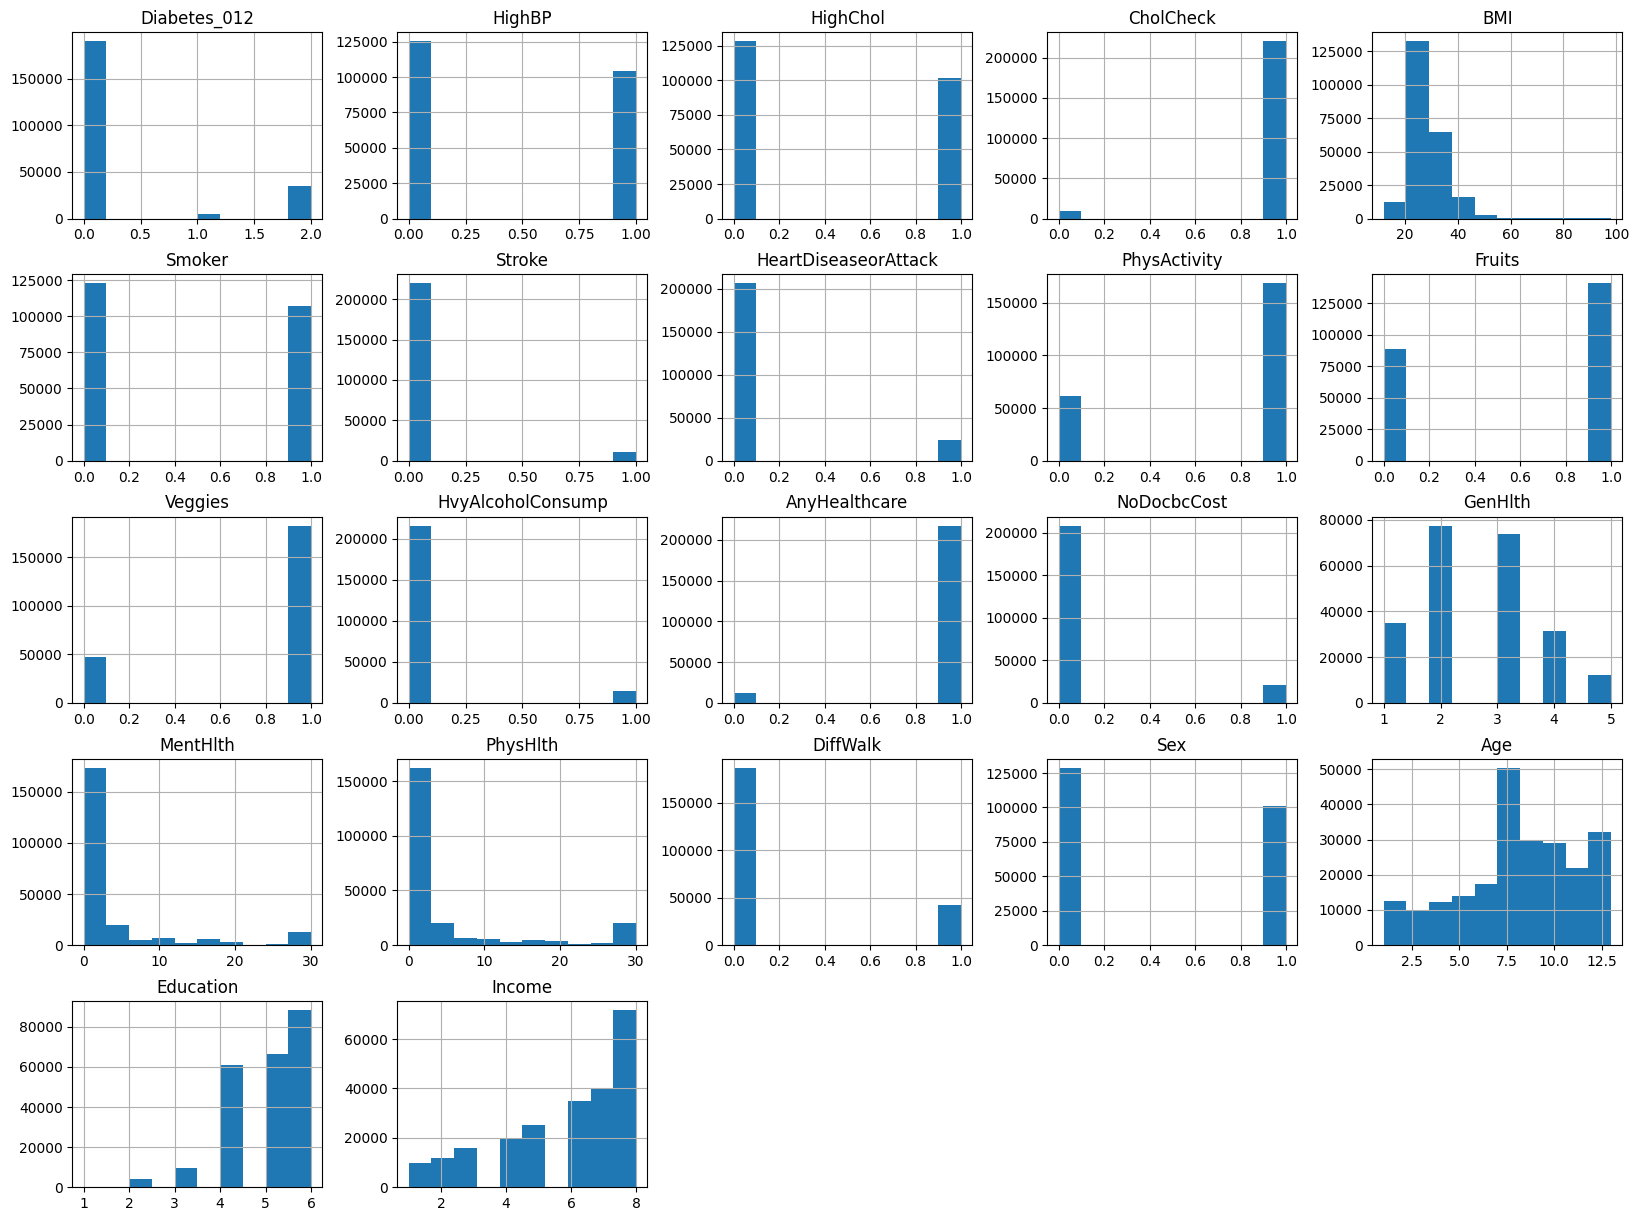

In [7]:
# visualizing data in histograms for understanding
data.hist(figsize=(20,15));

Text(0.5, 1.0, 'Correlation of features')

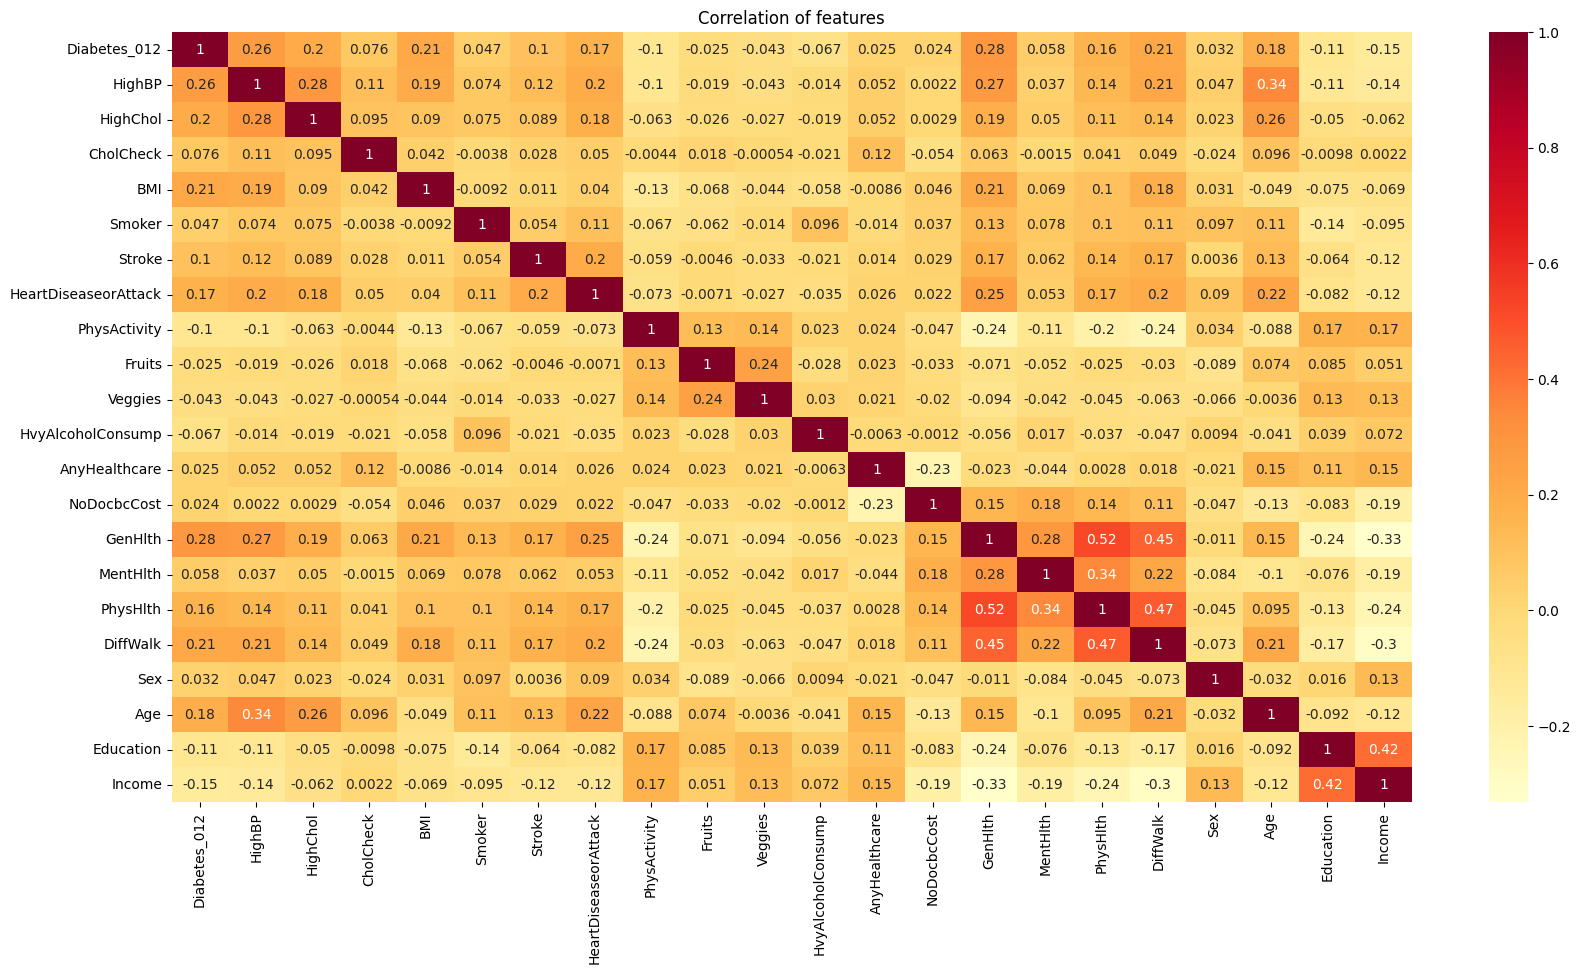

In [8]:
# correlaton heatmap 
plt.figure(figsize = (20,10))
corrmat = data.corr()
sns.heatmap(corrmat, annot=True, cmap ='YlOrRd' )
plt.title("Correlation of features")

In [9]:
# checking the outliers for BMW feature
# sns.boxplot(data["BMI"])

# condensing BMI into groups ( <20, 20 - 50, 50<)


BMI_0 = data.iloc[np.where(data["BMI"]<=20)]
BMI_1 = data.iloc[np.where((data["BMI"]>20)&(data["BMI"]<=50))]
BMI_2 = data.iloc[np.where(data["BMI"]>50)]

print("len of BMI_0 : ", len(BMI_0))
print("len of BMI_1 : ", len(BMI_1))
print("len of BMI_2 : ", len(BMI_2))

# checking for percentage of patients with diabetes in each group


print("BMI_0: \n\n ", ((BMI_0["Diabetes_012"].value_counts() / BMI_0.shape[0])) *100)
print("BMI_1: \n\n ", ((BMI_1["Diabetes_012"].value_counts() / BMI_1.shape[0])) *100)
print("BMI_2: \n\n ", ((BMI_2["Diabetes_012"].value_counts() / BMI_2.shape[0])) *100)

len of BMI_0 :  12204
len of BMI_1 :  215402
len of BMI_2 :  2175
BMI_0: 

  0.0    94.608325
2.0     4.465749
1.0     0.925926
Name: Diabetes_012, dtype: float64
BMI_1: 

  0.0    82.220221
2.0    15.714339
1.0     2.065440
Name: Diabetes_012, dtype: float64
BMI_2: 

  0.0    64.597701
2.0    32.321839
1.0     3.080460
Name: Diabetes_012, dtype: float64


# **2. model**

In [10]:
data = pd.read_csv('./data/diabetes_012_health_indicators_BRFSS2015.csv')

In [11]:
# buidling model
features = data.drop('Diabetes_012',axis=1)
target = data['Diabetes_012']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [12]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(202944, 21)
(50736, 21)
(202944,)
(50736,)


In [13]:
# Using SMOTE for imbalanced classification
smt=SMOTE(random_state=42)
X_train_res,Y_train_res=smt.fit_resample(features_train, target_train.ravel())

# **3.Hyperopt**

In [14]:
data = pd.read_csv('./data/diabetes_012_health_indicators_BRFSS2015.csv')
features = data.drop('Diabetes_012',axis=1)
groundtruth = data['Diabetes_012']

In [20]:
#target variable Diabetes_012:
#- 0 : no diabetes/ only during pregnancy
#- 1 : prediabetes
#- 2 : diabetes

### Classifier: #######################################################################################################

def no_diabetes_classifier(groundtruth) -> bool:
    if (groundtruth == 0):
        return (True)
    else: 
        return False

def diabetes_classifier(groundtruth) -> bool:     
    if (groundtruth == 2.0):
        return(True) 
    else:
        return(False)

def classifier(features):
    predictions = []
    for i in range(0, len(features)):
        # is it diabetes?
        if ((diabetes_classifier(features[i]))):
            predictions.append(2.0)
        # is it no diabetes?
        elif (no_diabetes_classifier(features[i])):
            predictions.append(0.0)
        # its neither, so patient is at risk
        else: predictions.append(1.0)
    # print(predictions)
    return predictions

In [16]:
# define performance metrics (True negatives, false negatives, true positives, false positives, recall, specificity, precision)
    # recall = Sensitifity = True Positive Rate
    # specificity = True Negative Rate
    # precision = TP / (TP + FP)

def calc_metrics(predictions, groundtruth):
    # predictions = predictions
    TP_no_diabetes = TN_prediabetes = TN_diabetes = TN_no_diabetes = TN_diabetes = TP_prediabetes = TP_diabetes = FP_no_diabetes = FN_diabetes = FN_prediabetes = FP_diabetes = FP_prediabetes = FN_no_diabetes = 0
    for i in range(0, len(predictions)):
        if (predictions[i] == groundtruth[i]):
            if (predictions[i] == 0):
                TP_no_diabetes += 1
                TN_prediabetes += 1
                TN_diabetes += 1
            elif (predictions[i] ==1):
                TP_prediabetes += 1
                TN_diabetes += 1
                TN_no_diabetes += 1
            else : 
                TP_diabetes += 1
                TN_no_diabetes += 1
                TN_prediabetes += 1
                
        elif (predictions[i] == 0):
            if (groundtruth[i] == 1):
                FP_no_diabetes += 1
                FN_prediabetes += 1
                TN_diabetes += 1
            elif (groundtruth[i] == 2):
                FP_no_diabetes += 1
                FN_diabetes += 1
                TN_prediabetes += 1
                
        elif (predictions[i] == 1):
            if (groundtruth[i] == 0):
                FP_prediabetes += 1
                FN_no_diabetes += 1
                TN_diabetes += 1
            elif(groundtruth[i] == 2):
                FP_prediabetes += 1
                FN_diabetes += 1
                TN_no_diabetes+= 1
                
        elif (predictions[i] == 2):
            if (groundtruth[i] == 0):
                FP_diabetes += 1
                FN_no_diabetes += 1
                TN_prediabetes += 1
            elif(groundtruth[i] == 1):
                FP_diabetes += 1
                FN_prediabetes += 1
                TN_no_diabetes += 1
                
    TP_total = TP_diabetes + TP_no_diabetes + TP_prediabetes 
    TN_total = TN_diabetes + TN_no_diabetes + TN_prediabetes
    FP_total = FP_diabetes + FP_no_diabetes + FP_prediabetes
    FN_total = FN_diabetes + FN_no_diabetes + FN_prediabetes 
    recall = TP_total/ (TP_total + FN_total)
    specificity =  TN_total / (TN_total + FP_total)
    precision = (TP_total / (TP_total + FP_total))
    return (recall, specificity, precision)


recall, specificity, precision = calc_metrics(predictions, groundtruth)
print (recall, specificity, precision)
    

1.0 1.0 1.0


In [22]:
# Hyperopt attempt

### Constants ##############################################################################################################

# amount of trials
MAX_EVALS = 3

# One 'run' equals one fmin-execution where each run for a number of x trials
SEARCH_SPACE = [hp.uniform('test', 0, 1)]

### Optimizaion ##############################################################################################################

def cost_function(features):
    predictions = classifier(groundtruth)
    recall, specifity, precision = calc_metrics(predictions, groundtruth)
    # print(f"recall: {recall}")
    # print(f"specificity: {specifity}")
    # specifity is maximized (= minimizes not recognized diabetes cases)
    print(f"Specifity (TN-Rate): {specifity}")
    return {'loss': - specifity , 'status': STATUS_OK }

trials = Trials()
best = fmin(cost_function,
    space = SEARCH_SPACE,
    algo = tpe.suggest,
    max_evals = MAX_EVALS, 
    trials = trials)

print(best)

Specifity (TN-Rate): 1.0                             
Specifity (TN-Rate): 1.0                                         
Specifity (TN-Rate): 1.0                                         
100%|██████████| 3/3 [00:03<00:00,  1.10s/trial, best loss: -1.0]
{'test': 0.7657825928309511}
